<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>

# <center> Идентификация пользователей по посещенным веб-страницам</center>
<center> <img align=center src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'></center>
<center>Автор материала: Пугачева Алиса</center>

Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать.
Задача заключается в том, чтобы по последовательности сайтов предсказать, принадлежит ли эта последовательность интересующему нас пользователю Alice, или другому. То есть решается задача бинарной классификации.
В качестве исходных данных, на которых требуется обучить модель, имеется несколько файлов, соответствующих пользователям, каждый из которых содержит таблицу вида:

## Описание исходных и обработанных данных и признаков

In [12]:
import pandas as pd
pd.read_csv('capstone_user_identification/3users/user0001.csv').head(2)

,timestamp,site
0,2013-11-15 09:28:17,vk.com
1,2013-11-15 09:33:04,oracle.com


В [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) на Kaggle исходные данные предобработанны таким образом, что представляют из себя таблицы, где строка - последовательность веб-страниц, метки времени захода на соотвествующий сайт и меткой пользователя:

In [13]:
import os
PATH_TO_DATA = ('capstone_user_identification')

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id', parse_dates=['time1'])

train_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0


## Первичный анализ и предобработка признаков

Посмотрим, как распределены по времени сессии в обучающей и тестовой выборке:

In [14]:
train_df.time1.min(), train_df.time1.max(), test_df.time1.min(), test_df.time1.max()

(Timestamp('2013-01-12 08:05:57'),
 Timestamp('2014-04-30 23:39:53'),
 Timestamp('2014-05-01 17:14:03'),
 Timestamp('2014-12-05 23:26:53'))

Видим, что временные отрезки(начала сессий) не пересекаются.
В связи с этим, сортируем сессии в обучающей выборке по времени (по полю time1)

In [15]:
train_df = train_df.sort_values(by='time1')
train_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21669 to 204762
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(2), object(9)
memory usage: 42.6+ MB


Сессии ограничены количеством сайтов (10) или длительностью сессии (30 мин)

Судя по входным данным, некоторые строки имеют пропуски, когда длительность сессии больше получаса.

Кроме train- и test- таблиц, у нас есть словарь всех сайтов site_dict:

In [17]:
import pickle
with open('capstone_user_identification/site_dic.pkl', 'rb') as sd:
    site_dict = pickle.load(sd)
print(pd.Series(site_dict)[:10])
'Длина словаря сайтов: {}'.format(len(site_dict))

0.0-02.net                     24314
0.56.web1.im.weibo.com         43357
0.academia-assets.com          18340
0.academia-photos.com          32767
0.api.urban-rivals.com         35936
0.client-channel.google.com    47984
0.cyberprofs.com                1542
0.docs.google.com                775
0.drive.google.com               678
0.envato-static.com            30517
dtype: int64


'Длина словаря сайтов: 48371'

Взглянем, насколько распределены объекты по классам в обучающей выборке:

In [18]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

data = [go.Bar(y=list(train_df.target.value_counts()), x=train_df.target.value_counts().index)]
iplot(data)

Видим, что в обучающей выборке классы очень несбалансированы: один класс больше другого примерно в сто раз.

Объеденим обучающую и тестовую выборки без меток класса, чтобы производить преобразования и добавление новых признаков:

In [19]:
full_df = pd.concat([train_df.drop('target', axis=1), test_df])
full_df.shape

(336358, 20)

Выделим колонки сайтов и времени и поменяем тип колонок сайтов на int, заодно заменим пропуски сайтов на 0, так как нумерация сайтов в словаре site_dict начинается с единицы:

In [20]:
time_cols = ['time%s' % i for i in range(1, 11)]
site_cols = ['site%s' % i for i in range(1, 11)]
train_df[site_cols] = train_df[site_cols].fillna(0).astype(int)
full_df[site_cols] = full_df[site_cols].fillna(0).astype(int)
idx = train_df.shape[0]
full_df[site_cols].head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946


In [21]:
test_df[site_cols] = test_df[site_cols].fillna(0).astype(int)
test_df[site_cols].head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,29,35,22,321,23,2211,6730,21,44582,15336
2,782,782,782,782,782,782,782,782,782,782
3,55,55,55,55,55,55,55,55,1445,1445


### Трансформация временных меток в интервалы времени

In [22]:
import numpy as np
stamps = full_df[time_cols].apply(pd.to_datetime)
for t in stamps[:-1]:
    stamps[t] = np.log1p((stamps.shift(-1, axis=1)[t] - stamps[t])/np.timedelta64(1,'s'))
stamps.drop('time10', axis=1, inplace=True)

In [23]:
stamps.head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9
session_id,,,,,,,,,
21669,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54843,0.000000,7.487174,1.098612,NaN,NaN,NaN,NaN,NaN,NaN
77292,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000
114021,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147
146670,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000


Добавим в additional_data_df столбец timespan - разница между первым и последним сайтом в сессии.

## Генерация новых признаков

In [24]:
additional_data_df = pd.DataFrame(index = full_df.index)

### Количество уникальных сайтов в сессиях

Посмотрим на распределение количества уникальных сайтов в сессиях, и как оно различается в зависимости от пользователя:

In [25]:
train_df[site_cols].head(5).apply(lambda x: len(np.unique(x[x!=0])), axis=1)

session_id
21669     2
54843     2
77292     6
114021    5
146670    6
dtype: int64

In [26]:
train_df[site_cols].head(5)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [27]:
unique_count_sites_df = pd.DataFrame({'nunique_site_count' : train_df[site_cols].apply(lambda x: len(np.unique(x[x!=0])), axis=1), 'target' : train_df.target})
unique_count_sites_df.head()

,nunique_site_count,target
session_id,,
21669,2,0
54843,2,0
77292,6,0
114021,5,0
146670,6,0


In [28]:
data4 = [ go.Bar(
    x=unique_count_sites_df[unique_count_sites_df.target == 0]['nunique_site_count'].value_counts().index,
    y=unique_count_sites_df[unique_count_sites_df.target == 0]['nunique_site_count'].value_counts(),
    name='target 0'
), go.Bar(
    x=unique_count_sites_df[unique_count_sites_df.target == 1]['nunique_site_count'].value_counts().index,
    y=unique_count_sites_df[unique_count_sites_df.target == 1]['nunique_site_count'].value_counts(),
    name='target 1'
)]
layout = {'title': 'Distributions of amount of unique sites in sessions'}
fig = go.Figure(data=data4, layout=layout)
iplot(fig)

Добавим столбец 'nunique' в датафрейм additional_data_df:

In [29]:
#del unique_count_sites_df
additional_data_df['nunique'] = full_df[site_cols].apply(lambda x: len(np.unique(x[x!=0])), axis=1)

### Индикаторы популярных сайтов в сессии

#### Найдем наиболее популярные сайты в обучающей выборке среди всех пользователей

In [30]:
top_sites = pd.Series(train_df[site_cols].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(10)
top_sites

21     123776
0      122730
23      87619
782     77055
22      58258
29      54094
167     46405
780     43841
778     38194
52      36085
dtype: int64

In [31]:
#удалим из этого списка 0, которым заменили пропуски
top_sites.pop(0)

122730

In [32]:
top_site_names = []
for s in top_sites.index:
    top_site_names.append(list(site_dict.keys())[list(site_dict.values()).index(s)])
    print(top_site_names[-1])

www.google.fr
www.google.com
annotathon.org
apis.google.com
www.facebook.com
www.bing.com
blast.ncbi.nlm.nih.gov
www.ncbi.nlm.nih.gov
clients1.google.com


In [33]:
# Alice's preferences
top_sites_alice = pd.Series(train_df[train_df.target==1][site_cols].values.flatten()
                           ).value_counts().sort_values(ascending=False).head(10)
top_sites_alice

77     1382
80     1354
76     1307
29      897
21      857
81      609
879     522
22      522
75      451
82      447
dtype: int64

Заметим, что сайты 21, 22 и 29 находятся в топе популярных и у Alice, и у остальных пользователей.

Посмотрим, как часто встречаются сайты, популярные у Alice, среди всех сессий выборки:

In [34]:
alices_pop_sites=[]
for s in top_sites_alice.index:
    alices_pop_sites.append(len(train_df[train_df.target==0][site_cols].values.flatten()[train_df[train_df.target==0][site_cols].values.flatten()==s]))

In [35]:
alices_top_names = []
for s in top_sites_alice.index:
    alices_top_names.append(list(site_dict.keys())[list(site_dict.values()).index(s)])

In [36]:
alices_top_names

['i1.ytimg.com',
 's.youtube.com',
 'www.youtube.com',
 'www.facebook.com',
 'www.google.fr',
 'r4---sn-gxo5uxg-jqbe.googlevideo.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'apis.google.com',
 's.ytimg.com',
 'r2---sn-gxo5uxg-jqbe.googlevideo.com']

In [37]:
data5 = [
    go.Bar(y=top_sites_alice, x=alices_top_names, name='among Alice'),
    go.Bar(y=alices_pop_sites, x=alices_top_names, name='among all another')
]
fig = go.Figure(data=data5, layout={'title': 'Distribution of alices most popular sites'})
iplot(fig)

Видим, что сайты, популярные у Alice, пользуются популярностью также и у остальных пользователей. Тем не менее, они будут нам полезны, добавим в датафрейм  additional_data_df индикатор захода на эти сайты:

In [38]:
additional_data_df['alices_top_site'] = full_df[site_cols].apply(lambda x: 1 if x.any() in list(top_sites_alice.index) else 0, axis=1)

Из-за того, что списки пересекаются, начиная уже с четвертого элемента, возможно, более показательно будет добавить индикатор захода в топ-3 популярных сайтов Alice.

In [39]:
additional_data_df['alices_top3_site'] = full_df[site_cols].apply(lambda x: 1 if x.any() in list(top_sites_alice.index)[:3] else 0, axis=1)

In [40]:
additional_data_df.head(10)

,nunique,alices_top_site,alices_top3_site
session_id,,,
21669,2,0,0
54843,2,0,0
77292,6,0,0
114021,5,0,0
146670,6,0,0
242171,5,0,0
57157,5,0,0
240201,6,0,0
210686,5,0,0


Кроме того, добавим индикатор захода на наиболее популярные сайты в выборке:

In [41]:
additional_data_df['top_site'] = full_df[site_cols].apply(lambda x: 1 if x.any() in list(top_sites.index) else 0, axis=1)

### День недели, час начала сессии, часть дня, индикатор выходного дня, месяц, год

In [42]:
additional_data_df['start_hour'] = full_df['time1'].apply(lambda x: x.hour)

In [43]:
additional_data_df['day_of_week'] = full_df['time1'].apply(lambda x: x.weekday())

In [44]:
additional_data_df['month'] = full_df['time1'].apply(lambda x: x.month)
additional_data_df['year'] = full_df['time1'].apply(lambda x: x.year)

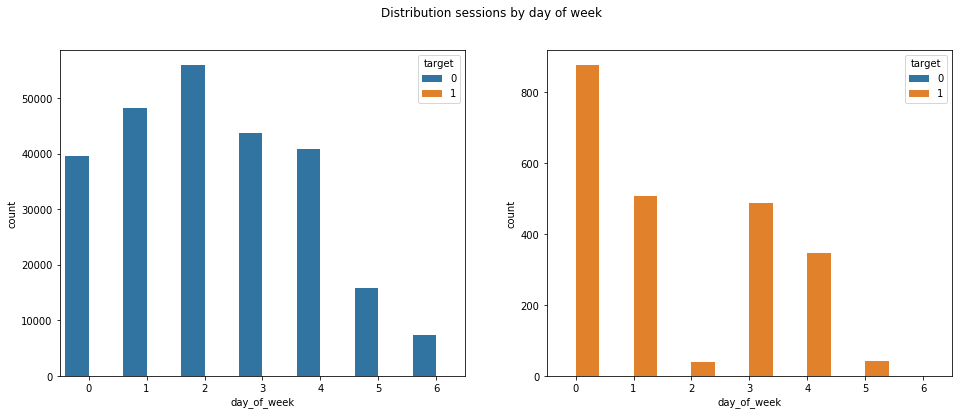

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
_, axes = plt.subplots(1, 2, figsize=(16,6))

sns.countplot(x=additional_data_df[:idx][train_df.target==0].day_of_week, hue=train_df.target, ax=axes[0]);
sns.countplot(x=additional_data_df[:idx][train_df.target==1].day_of_week, hue=train_df.target, ax=axes[1]);
_.suptitle('Distribution sessions by day of week'); # can also get the figure from plt.gcf()

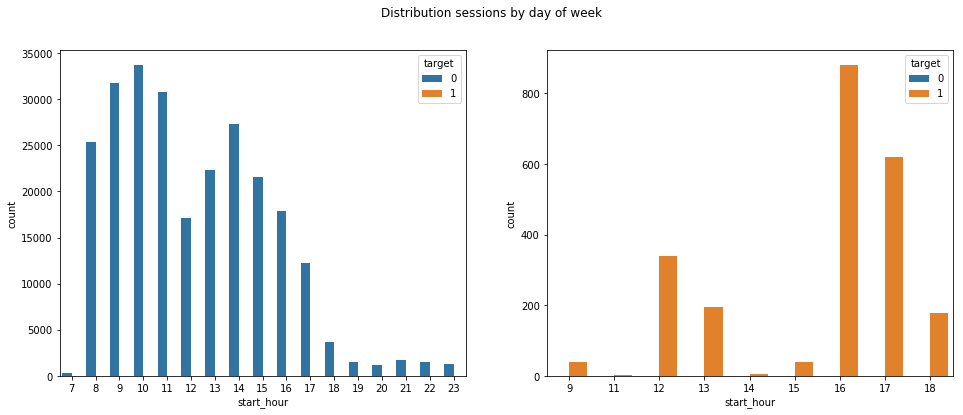

In [46]:
import seaborn as sns
_, axes = plt.subplots(1, 2, figsize=(16,6))

sns.countplot(x=additional_data_df[:idx][train_df.target==0].start_hour, hue=train_df.target, ax=axes[0]);
sns.countplot(x=additional_data_df[:idx][train_df.target==1].start_hour, hue=train_df.target, ax=axes[1]);
_.suptitle('Distribution sessions by day of week'); # can also get the figure from plt.gcf()

Видим, что у Alice довольно отличное от общей выборки время начала сессии. Укажем отдельным столбцом часть дня, соответсвующую start_hour:

In [47]:
def day_part(hour):
    if hour<9:
        return 'early_morning'
    elif hour<12:
            return 'morning'
    elif hour<16:
            return 'day'
    elif hour<19:
            return 'early evening'
    else:
        return 'evening'

In [48]:
additional_data_df['daypart'] = additional_data_df['start_hour'].apply(lambda x: day_part(x))

In [49]:
additional_data_df['weekend'] = additional_data_df['day_of_week'].apply(lambda x: 1 if x>4 else 0)

### Количество и длительность захода на сайт vk.com
Это мой "инсайт", который я отрыла, рассматривая файлы пользователей: некоторые пользователи вовсе не заходят на этот сайт, а Alice - довольно много.
Посчитаем количество захода на сайт за сессию, а также время, проведенное на сайте

In [50]:
site_vk = site_dict['vk.com']

In [51]:
len(train_df[train_df.target==0][site_cols].values.flatten()[train_df[train_df.target==0][site_cols].values.flatten()==site_vk])

1035

In [52]:
len(train_df[train_df.target==1][site_cols].values.flatten()[train_df[train_df.target==1][site_cols].values.flatten()==site_vk])

286

In [53]:
additional_data_df['vk.com'] = full_df[site_cols].apply(lambda x: len(x[x==site_vk]), axis=1)

In [54]:
#Среднее количество заходов на vk.com у Alice
additional_data_df[:idx][train_df.target == 1][['vk.com']].mean()

vk.com    0.12451
dtype: float64

In [55]:
#Среднее количество заходов на vk.com среди других пользователей
additional_data_df[:idx][train_df.target == 0][['vk.com']].mean()

vk.com    0.004119
dtype: float64

### Интервал времени между заходом на первый и последний сайт сессии

In [56]:
additional_data_df['timespan'] = stamps.sum(axis=1)

## Преобразуем категориальные признаки

In [57]:
add_data_df = pd.get_dummies(additional_data_df, columns=['start_hour', 'day_of_week', 'daypart', 'month'])

In [58]:
add_data_df.head()

,nunique,alices_top_site,alices_top3_site,top_site,year,weekend,vk.com,timespan,start_hour_7,start_hour_8,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
session_id,,,,,,,,,,,,,,,,,,,,,
21669,2,0,0,0,2013,1,0,0.000000,0,1,...,0,0,0,0,0,0,0,0,0,0
54843,2,0,0,0,2013,1,0,8.585786,0,1,...,0,0,0,0,0,0,0,0,0,0
77292,6,0,0,0,2013,1,0,2.772589,0,1,...,0,0,0,0,0,0,0,0,0,0
114021,5,0,0,0,2013,1,0,2.079442,0,1,...,0,0,0,0,0,0,0,0,0,0
146670,6,0,0,0,2013,1,0,1.386294,0,1,...,0,0,0,0,0,0,0,0,0,0


## Векторизуем данные сайтов

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
full_df[site_cols][:idx].to_csv('train_sessions_text.txt', sep=' ', index=None, header=None)
full_df[site_cols][idx:].to_csv('test_sessions_text.txt', sep=' ', index=None, header=None)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_sites = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_sites = cv.transform(inp_test_file)
X_train_sites.shape, X_test_sites.shape

((253561, 50000), (82797, 50000))

In [60]:
vocabulary_list = list(cv.vocabulary_.values())

## Создадим разбиение с помощью TimeSeriesSplit

In [61]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
time_split = TimeSeriesSplit(n_splits=10)

## Обучение модели

### Объединяем все датафреймы в один, и разбиваем обратно на обучающую и тестовую выбобрки

In [62]:
from scipy.sparse import hstack, vstack

In [63]:
train_sparse = hstack([X_train_sites, add_data_df[:idx].values], 'csr')
test_sparse = hstack([X_test_sites, add_data_df[idx:].values], 'csr')

In [64]:
with open('train_sparse.pkl', 'wb') as f:
    pickle.dump(train_sparse, f, protocol=2)
with open('test_sparse.pkl', 'wb') as f:
    pickle.dump(test_sparse, f, protocol=2)

### Создаем несколько моделей

#### Обучаем несколько моделей с параметрами по умолчанию, сравним качество

In [65]:
from sklearn.model_selection import cross_val_score

In [66]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier

In [67]:
import catboost

In [79]:
valid_idx = int(train_sparse.shape[0]*0.7)

In [89]:
train_x_sparse = train_sparse[:valid_idx]
train_valid_sparse = train_sparse[valid_idx:]

In [95]:
lr = LogisticRegression(random_state=17, solver='lbfgs', n_jobs=1).fit(train_x_sparse, train_df.target[:valid_idx])
sgd = SGDClassifier(random_state=17, max_iter=10000, loss='log').fit(train_x_sparse, train_df.target[:valid_idx])
#lsvc = LinearSVC(random_state=17).fit(train_x_sparse, train_df.target[:valid_idx])
gb = GradientBoostingClassifier(random_state=17).fit(train_x_sparse, train_df.target[:valid_idx])

In [98]:
from sklearn.metrics import roc_auc_score
for model in [lr,sgd, gb]:
    print(model, roc_auc_score(train_df.target[valid_idx:], model.predict_proba(train_valid_sparse)[:,1]))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False) 0.948511259106246
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=17, shuffle=True,
       tol=None, verbose=0, warm_start=False) 0.9538379520908232
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              preso

Лучший результат показал SGDClassifier. Буду использовать его.

## Настройка параметров модели, построение кривых валидации.

In [131]:
%%time
cv_lr = LogisticRegressionCV(Cs=np.logspace(-2, 1, 10), cv=3, scoring='roc_auc', random_state=17)
cv_lr.fit(train_x_sparse, train_df.target[:valid_idx])

print('Best C: {:3f}'.format(cv_lr.C_[0]))

Best C: 0.010000
CPU times: user 1min 42s, sys: 6.31 s, total: 1min 49s
Wall time: 1min 40s


In [105]:
from sklearn.model_selection import validation_curve
from sklearn.cross_validation import 

In [112]:
train_scores, test_scores = validation_curve(lr, train_sparse, train_df.target, cv=time_split, scoring='roc_auc', param_name='C', param_range=np.logspace(-1,1,5), verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished


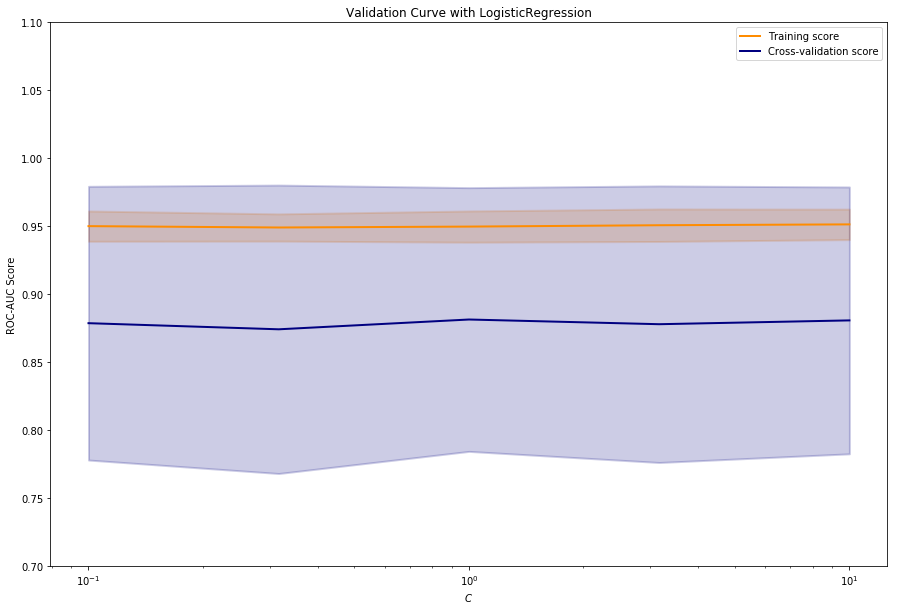

In [149]:
fig = plt.figure(figsize=(15,10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with LogisticRegression")
plt.xlabel("$C$")
plt.ylabel("ROC-AUC Score")
plt.ylim(0.7, 1.1)
lw = 2
plt.semilogx(np.logspace(-1,1,5), train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(np.logspace(-1,1,5), train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.semilogx(np.logspace(-1,1,5), test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
plt.fill_between(np.logspace(-1,1,5), test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

Я взяла довольно узкий промежуток С, поэтому качество не очень разнится.

In [139]:
cv_lr.coef_.argmax()

50033

In [142]:
temp_sparse = hstack([train_sparse[:,:cv_lr.coef_.argmax()], train_sparse[:,cv_lr.coef_.argmax()+1:]])

In [143]:
lr_new = LogisticRegression(solver='lbfgs', random_state=17).fit(temp_sparse, train_df.target)


In [145]:
res_t=lr_new.predict_proba(hstack([test_sparse[:,:cv_lr.coef_.argmax()], test_sparse[:,cv_lr.coef_.argmax()+1:]]))

In [148]:
write_to_submission_file(res_t[:,1], 'kaggle_answer_file.csv')

Настроим параметры модели

In [151]:
gs = GridSearchCV(lr_new, param_grid={'C':np.logspace(-2,1,10)}, scoring='roc_auc', cv=time_split)

In [ ]:
gs.fit(temp_sparse, train_df.target)

## Оценим важность признаков
Построим график для наиболее весомых признаков

In [120]:
importance_features_pos = np.argsort(cv_lr.coef_.ravel())[-20:]

importance_features_neg = np.argsort(cv_lr.coef_.ravel())[:20]

In [121]:
def feature_names(importance_features):
    xticks = []
    for f in importance_features:
        if f>=50000:
            xticks.append(add_data_df.columns[f-50000])
        else:
            sites = list(cv.vocabulary_.keys())[vocabulary_list.index(f)]
            harmon = []
            for s in sites.split():
                harmon.append(list(site_dict.keys())[list(site_dict.values()).index(int(s))]) 
            xticks.append(','.join(harmon))
    return(xticks)

In [124]:
data6 = [
    go.Bar(y=cv_lr.coef_.ravel()[importance_features_neg], x=feature_names(importance_features_neg), name='negative features'),
    go.Bar(y=cv_lr.coef_.ravel()[importance_features_pos], x=feature_names(importance_features_pos), name='positive features')
]

fig = go.Figure(data=data6, layout={'title': 'Coefficients of most important featutes'})
iplot(fig)

Видим, что среди наиболее важных признаков преимущественно сайты, на которые, например, заходила только Alice, или, наоборот, те, на которые она не заходила никогда. Из мною сгенерированных признаков сюда попали только месяц(month_9), время (start_hour_12, start_hour_13) и часть дня (daypart_early_morning)

In [128]:
lr_res = LogisticRegression(C=cv_lr.C_[0], random_state=17, solver='lbfgs')
lr_res.fit(train_sparse, train_df.target)
test_pred3 = lr_res.predict_proba(test_sparse)[:,1]

In [ ]:
result_answer.shape

In [129]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [130]:
write_to_submission_file(test_pred3, 'kaggle_answer_file.txt')

## Заключение. Итоги

В ходе проекта было реализованы следующие шаги:
- генерация новых признаков, таких как время начала сессии, количество уникальных сайтов в сессии, день недели, часть дня, время сессии
- предобработка данных включала в себя сортировку данных по времени, преобразование данных сайтов в разреженную матрицу, логарифмирование длительности сессии, преобразование порядковых признаков в категориальные.
- обучение модели логистической регрессии, обучение модели регрессии случайного леса, усреднение результатов.